## Boston Graph Data
Download the Graph (nodes = intersections, edges = road segments) and save to "boston_walk.graphml". 

In [ ]:
import osmnx as ox

In [ ]:
"""
# Uncommet to download data through osmnx, or run the cell below to load in the graphml


# settings
ox.settings.use_cache = True
ox.settings.timeout = 180

# download
G = ox.graph_from_place("Boston, MA", network_type="walk")

# projection from WGS84 to CRS
G_proj = ox.project_graph(G)

# save
ox.save_graphml(G_proj, filepath="boston_walk.graphml")

print("Saved")
"""

Saved


Load the saved map directly to aviod waiting for downloading.

In [11]:
# load map
G_proj = ox.load_graphml("boston_walk.graphml")

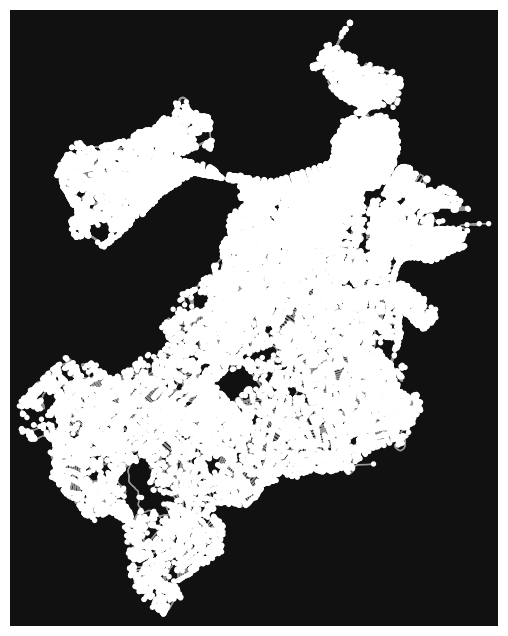

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [52]:
ox.plot_graph(G_proj)

## Useful attributes in G
node_gdf:
- osmid: id of the node. Will be used in representing u and v for edges.
- x (in CRS)
- y (in CRS)

edges_gdf: 
- 'name': Street names
- 'length': combine with risk score to create a value for edges' weight
- 'geometry': LineString. by connecting the points in the LineString, we can draw out a line to represent the street

In [ ]:
print(type(G_proj))                        
print(G_proj.number_of_nodes(), G_proj.number_of_edges())
print()

# node example
n, data = next(iter(G_proj.nodes(data=True)))
print("node id:", n)
print("node attrs:", data)   
print()            

# edge example
(u, v, k, edata) = next(iter(G_proj.edges(keys=True, data=True)))
print("edge:", (u, v, k))
print("edge attrs:", edata)                


<class 'networkx.classes.multidigraph.MultiDiGraph'>
53002 155656

node id: 61178875
node attrs: {'y': 4694304.575952687, 'x': 328698.1155186846, 'street_count': 4}

edge: (61178875, 7893894562, 0)
edge attrs: {'osmid': 8649976, 'highway': 'residential', 'lanes': '2', 'maxspeed': '25 mph', 'name': 'Crescent Street', 'width': '9.8', 'oneway': False, 'reversed': True, 'length': 8.404560910690266}


In [48]:
import geopandas as gpd
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_proj)
nodes_gdf.head()

,y,x,street_count,highway,junction,railway,ref,geometry
osmid,,,,,,,,
61178875,4.694305e+06,328698.115519,4,NaN,NaN,NaN,NaN,POINT (328698.116 4694304.576)
7893894562,4.694296e+06,328699.734200,4,crossing,NaN,NaN,NaN,POINT (328699.734 4694296.336)
7890351129,4.694316e+06,328696.707088,4,crossing,NaN,NaN,NaN,POINT (328696.707 4694316.355)
7478206090,4.694313e+06,328746.299754,3,NaN,NaN,NaN,NaN,POINT (328746.3 4694312.785)
61339242,4.687233e+06,330281.497700,3,NaN,NaN,NaN,NaN,POINT (330281.498 4687232.883)


In [49]:
edges_gdf.head()

osmid      highway  \
u          v          key                                                  
61178875   7893894562 0                             8649976  residential   
           7890351129 0                             9429555  residential   
           7478206090 0    [426653648, 8651189, 1086801839]      primary   
7893894562 61178875   0                             8649976  residential   
           7893291977 0                             8649976  residential   

                          lanes maxspeed  \
u          v          key                  
61178875   7893894562 0       2   25 mph   
           7890351129 0       1   25 mph   
           7478206090 0       2   25 mph   
7893894562 61178875   0       2   25 mph   
           7893291977 0       2   25 mph   

                                                            name  \
u          v          key                                          
61178875   7893894562 0                          Crescent Street   
           7890351129 0                          Crescent Street   
           7478206090 0    [Cambridge Street, Washington Street]   
7893894562 61178875   0                          Crescent Street   
           7893291977 0                          Crescent Street   

                                  width  oneway reversed     length  \
u          v          key                                             
61178875   7893894562 0             9.8   False     True   8.404561   
           7890351129 0             7.6   False     True  11.874485   
           7478206090 0    [19.5, 21.3]   False    False  48.776634   
7893894562 61178875   0             9.8   False    False   8.404561   
           7893291977 0             9.8   False     True  57.969773   

                                                                    geometry  \
u          v          key                                                      
61178875   7893894562 0    LINESTRING (328698.116 4694304.576, 328699.734...   
           7890351129 0    LINESTRING (328698.116 4694304.576, 328696.707...   
           7478206090 0    LINESTRING (328698.116 4694304.576, 328714.355...   
7893894562 61178875   0    LINESTRING (328699.734 4694296.336, 328698.116...   
           7893291977 0    LINESTRING (328699.734 4694296.336, 328710.863...   

                          service  ref access bridge junction tunnel  
u          v          key                                             
61178875   7893894562 0       NaN  NaN    NaN    NaN      NaN    NaN  
           7890351129 0       NaN  NaN    NaN    NaN      NaN    NaN  
           7478206090 0       NaN  NaN    NaN    NaN      NaN    NaN  
7893894562 61178875   0       NaN  NaN    NaN    NaN      NaN    NaN  
           7893291977 0       NaN  NaN    NaN    NaN      NaN    NaN

## Points Sampling from Edges
Use the `geometry` (LineString) to get out points every 20 meters for each edges as representation. 
1. Get out some points from the edge
2. Put into the trained model and predict the risk score for each points.
    - if the train
3. Take average (or maximum) to get the value for the whole edge.
4. (Create a funciton to) Combine the risk score with length --> weight edge.

In [ ]:
from shapely.geometry import LineString

In [ ]:
def sample_points_by_spacing(line: LineString, spacing_m: float = 20.0, include_ends: bool = False):
    L = float(line.length)
    if L <= 1e-6:
        return []
    if L <= spacing_m:
        # use midpoint for shorter edges
        pts = [line.interpolate(0.5, normalized=True)]
        if include_ends:
            pts = [line.interpolate(0.0, normalized=True)] + pts + [line.interpolate(1.0, normalized=True)]
        return pts

    n = int(L // spacing_m) 
    ts = [ (i+0.5)/(n+1) for i in range(n+1) ]  
    pts = [ line.interpolate(t, normalized=True) for t in ts ]
    if include_ends:
        pts = [line.interpolate(0.0, normalized=True)] + pts + [line.interpolate(1.0, normalized=True)]
    return pts


In [ ]:
# test for points sampling
test = edges_gdf.iloc[0, :]['geometry']

points = sample_points_by_spacing(test, 2)
points 

[<POINT (328698.277 4694303.752)>,
 <POINT (328698.601 4694302.104)>,
 <POINT (328698.925 4694300.456)>,
 <POINT (328699.249 4694298.808)>,
 <POINT (328699.572 4694297.16)>]

In [ ]:
# test for transforming
"""
Assume the risk_score_prediction model takes latitude and longitude as input, so we need to transform CRS to WGS84.
"""
from pyproj import Transformer

to_wgs84 = Transformer.from_crs(G_proj.graph["crs"], "EPSG:4326", always_xy=True).transform

for point in points:
    lon, lat = to_wgs84(point.x, point.y)
    print(lon, lat)

-71.08087538999752 42.38214212000028
-71.08087096999422 42.38212736000066
-71.08086654999312 42.38211260000078
-71.08086212999423 42.38209784000064
-71.08085770999752 42.38208308000028


## Final Step: Use Networkx to run Dijkstra or A*
not yet tested

In [ ]:
"""
import networkx as nx


# example of adding new attribute
for u, v, k in G_proj.edges(keys=True):
    length = G_proj[u][v][k]["length"]
    risk = G_proj[u][v][k]["risk"]
    G_proj[u][v][k]["edge_cost"] = length + 5 * risk

# example of running Dijkstra or A*
route = nx.shortest_path(G_proj, source=u, target=v, weight="edge_cost")
route = nx.astar_path(G_proj, source=u, target=v, weight="edge_cost")

# use plot_route to plot the result 
ox.plot_route(G_proj, route)
"""